# The Communication Value of Noisy Quantum Channels

The communication value quantifies the performance of classical communication over a black-box (quantum) channel.
For a quantum channel $\mathcal{N}$, the communication value is defined as

$$
\text{cv}(\mathcal{N}) = \max_{\{\rho_x\}_x,\{\Pi_y\}_y} \sum_{x=y} \text{Tr}[\Pi_y \mathcal{N}(\rho_x)].
$$

If the Hilbert spaces of $\rho_x$ and $\Pi_y$ are both dimension $d$, then it is sufficient to consider $x,y\in[d^2]:=\{1,2,\dots,d^2\}$.
General states and POVMs should be considered, however, for simplicity, we'll consider pure states and combinations of PVM measurements.

In this notebook, we'll consider the communication value of noisy communication channels.
These channels do not express nonlocality, however, non-multiplicative scaling behaviors have been identified for certain noisy channels.

<div>
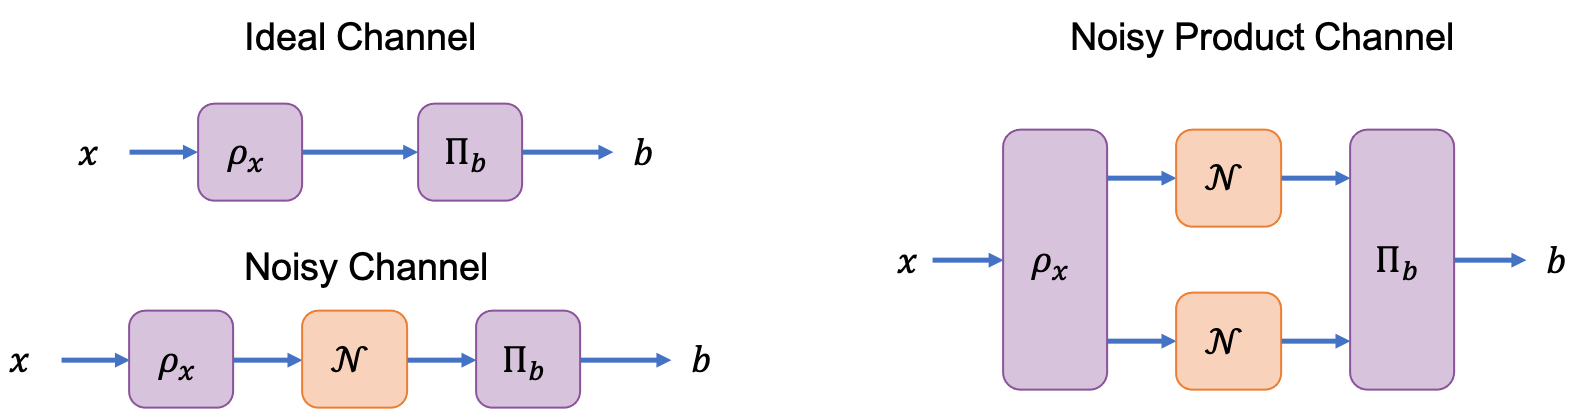
</div>

<!-- [<img src="images/noisy_local_signaling_scenario.png" width="600"/>](images/noisy_local_signaling_scenario.png) -->

In [20]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
import time

We'll begin with ideal, single-qubit communication with 4 state encodings and 4 measurement outcomes.

In [2]:
pure_qubit_dev = qml.device("default.qubit", wires=1)

@qml.qnode(pure_qubit_dev)
def cv_qubit_circuit(settings):
    (θ_state, θ_measurement) = settings
    qml.RY(θ_state, wires=0)
    qml.RY(θ_measurement, wires=0)
    
    # return array probs
    # probs[0] -> +1 and probs[1] -> -1
    return qml.probs(wires=0)

In [3]:
cv_qubit_circuit((np.pi,0))

tensor([3.74939946e-33, 1.00000000e+00], requires_grad=True)

In [4]:
print(cv_qubit_circuit.draw())

 0: ──RY(3.14)──RY(0)──┤ Probs 



In [5]:
noisy_qubit_dev = qml.device('default.mixed', wires=1)

def _cv_noisy_qubit_circuit(settings, channel=None, *channel_params):
    (θ_state, θ_measurement) = settings
    qml.RY(θ_state[0], wires=0)
    
    if channel != None:
        channel(*channel_params, wires=0)
    
    qml.RY(θ_measurement[0], wires=0)
    
    # return array probs
    # probs[0] -> +1 and probs[1] -> -1
    return qml.probs(wires=0)

@qml.qnode(noisy_qubit_dev)
def cv_noisy_qubit_circuit(settings):
    return _cv_noisy_qubit_circuit(settings, qml.AmplitudeDamping, 0.5)


In [6]:
def cv_settings(d):
    n = int(np.log2(d))
    
    θ_states = 2*np.pi*np.random.random((d**2, n)) - np.pi
    θ_measurements = 2*np.pi*np.random.random((d,n)) - np.pi
    
    return (θ_states, θ_measurements)

def _cv_cost(settings, circuit):
    θ_states, θ_measurements = settings
    
    d2 = len(θ_states)
    d = int(np.sqrt(d2))
    
    cv = 0
    for x in range(d2):
        y = x // d
        
        probs = circuit((θ_states[x], θ_measurements[y]))
        cv += probs[x % d]
    
    return -(cv)/d

cv_ideal_qubit_cost = lambda settings: _cv_cost(settings, cv_qubit_circuit)
cv_noisy_qubit_cost = lambda settings: _cv_cost(settings, cv_noisy_qubit_circuit)   

The BB84 states can be used to maximize the communication value to achieve a score of $2$.

In [7]:
θ_bb84_states = [0, np.pi, np.pi/2, 3*np.pi/2]
θ_bb84_measurements = [0, -np.pi/2]

cv_ideal_qubit_cost((θ_bb84_states, θ_bb84_measurements))

tensor(-2., requires_grad=True)

In [8]:
def cv_gradient_descent(d, cost, step_size=0.1, num_steps=500):
    opt = qml.GradientDescentOptimizer(stepsize=step_size)    

    # initial settings
    settings = cv_settings(d)
    cvs = []
    samples = []

    # performing gradient descent
    for i in range(num_steps):
        settings = opt.step(cost, settings)
    
        if i%5 == 0:
            print("iteration : ", i)
        
        if i%25 == 0:
            cv = -(cost(settings))
            cvs.append(cv)
            samples.append(i)

            print("cv : ", cv)
            print("settings :\n", settings, "\n")

    final_cv = -(cost(settings))
    final_settings = settings
    samples.append(num_steps-1)
    cvs.append(final_cv)

    print("final cv : ", final_cv)
    print("final settings : ", settings, "\n")
    
    return final_cv, settings, cvs, samples

In [9]:
%%time

d2_final_cv, d2_settings, d2_cvs, d2_samples = cv_gradient_descent(2, cv_noisy_qubit_cost)

iteration :  0
cv :  1.0556729661743582
settings :
 [array([[0.44239164],
       [1.60893652],
       [0.78712161],
       [0.37401316]]), array([[-0.65125902],
       [ 3.0624975 ]])] 

iteration :  5
iteration :  10
iteration :  15
iteration :  20
iteration :  25
cv :  1.18901471211124
settings :
 [array([[0.49375315],
       [1.91158462],
       [1.03130408],
       [0.2693776 ]]), array([[-0.30005464],
       [ 3.26193494]])] 

iteration :  30
iteration :  35
iteration :  40
iteration :  45
iteration :  50
cv :  1.3327223308970488
settings :
 [array([[0.42122402],
       [2.21338736],
       [1.34716539],
       [0.10563486]]), array([[-0.04472457],
       [ 3.52448326]])] 

iteration :  55
iteration :  60
iteration :  65
iteration :  70
iteration :  75
cv :  1.4409729194548948
settings :
 [array([[ 0.29642112],
       [ 2.42949185],
       [ 1.63292779],
       [-0.10888636]]), array([[0.10197188],
       [3.76505708]])] 

iteration :  80
iteration :  85
iteration :  90
iteration 

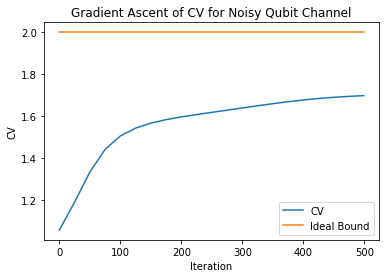

In [10]:
# Plot the communication value
plt.plot(d2_samples, d2_cvs, label = "CV")
plt.plot(d2_samples, [2]*len(d2_samples), label = "Ideal Bound")
plt.title("Gradient Ascent of CV for Noisy Qubit Channel")
plt.xlabel("Iteration")
plt.ylabel("CV")
plt.legend()
plt.show()

Note that the ideal bound is not achieved because there is noise on the qubit.

## Two-Qubit Channels

We now test the multiplicativity of a two-qubit channel.

In [11]:
from pennylane.operation import Channel

# This is just a test channel, no expectation for this
# to do anything special
class TwoQubitEntangledPauli(Channel):

    num_params = 1
    num_wires = 2
    par_domain = "R"
    grad_method = "A"
    grad_recipe = ([[1, 0, 1], [-1, 0, 0]],)

    @classmethod
    def _kraus_matrices(cls, *params):
        p = params[0]
        σx = np.array([[0, 1], [1, 0]])
        σy = np.array([[0, -1j], [1j, 0]])
        σz = np.array([[1, 0], [0, -1]])
        
        K0 = np.sqrt(1 - p) * np.eye(4)
        K1 = np.sqrt(p / 3) * np.kron(σx,σx)
        K2 = np.sqrt(p / 3) * np.kron(σy,σy)
        K3 = np.sqrt(p / 3) * np.kron(σz,σz)
        return [K0, K1, K2, K3]

We need a 2-qubit `"default.mixed"` device to implement our channel on.

In [12]:
noisy_2qubit_dev = qml.device('default.mixed', wires=2)

# making mixed simulator aware of the new channel
noisy_2qubit_dev.operations.update(["TwoQubitEntangledPauli"])

def _cv_noisy_2qubit_circuit(settings, channel=None, *channel_params):
    (θ_state, θ_measurement) = settings
        
    qml.RY(θ_state[0], wires=0)
    qml.RY(θ_state[1], wires=1)
    qml.CNOT(wires=[0,1])
    
    if channel != None:
        channel(*channel_params, wires=[0,1])
    
    qml.CNOT(wires=[0,1])
    qml.RY(θ_measurement[0], wires=0)
    qml.RY(θ_measurement[1], wires=1)
    
    return qml.probs(wires=[0,1])

@qml.qnode(noisy_2qubit_dev)
def cv_noisy_2qubit_circuit(settings):
    return _cv_noisy_2qubit_circuit(settings, TwoQubitEntangledPauli, 0)

cv_noisy_2qubit_cost = lambda settings: _cv_cost(settings, cv_noisy_2qubit_circuit)

Gradient descent optimization of two-qubit channel.

In [13]:
%%time

d4_final_cv, d4_settings, d4_cvs, d4_samples = cv_gradient_descent(
    4, cv_noisy_2qubit_cost, step_size=0.2, num_steps=400
)

iteration :  0
cv :  0.8144797210859844
settings :
 [array([[ 2.26377265,  0.61025   ],
       [ 2.79042216, -0.22223737],
       [ 1.96224509, -3.06832754],
       [-3.06429501, -1.75492713],
       [ 1.34180019,  1.18826628],
       [-0.53213897,  1.59093908],
       [ 0.46552981, -0.3403611 ],
       [ 0.1171551 , -2.88107851],
       [-0.61254938, -3.06661583],
       [ 0.83590816, -1.58664743],
       [-2.41119964,  2.83747373],
       [-2.22360858,  3.05106958],
       [-2.90814068, -2.02760737],
       [-1.99665603,  2.98124056],
       [ 1.81293598,  2.73201443],
       [-2.52359721,  2.50488883]]), array([[-0.30363398,  0.71193852],
       [-2.80396195, -2.75836507],
       [-0.7669083 ,  0.45954124],
       [-1.56476263,  0.67688333]])] 

iteration :  5
iteration :  10
iteration :  15
iteration :  20
iteration :  25
cv :  1.7236389764019304
settings :
 [array([[ 1.78585186,  0.38296446],
       [ 2.78216611, -0.20424074],
       [ 2.02011925, -2.89310841],
       [-2.95340468

iteration :  230
iteration :  235
iteration :  240
iteration :  245
iteration :  250
cv :  3.492744355111568
settings :
 [array([[ 1.04934037,  1.25055624],
       [ 1.1136333 , -1.81110176],
       [ 3.28404109, -4.12668111],
       [-2.09854256, -1.88947549],
       [ 2.77600117,  0.96211058],
       [-0.64868229,  1.62540319],
       [-0.35813752,  0.95515505],
       [-0.36054822, -2.18227752],
       [ 0.50807194, -4.84264167],
       [ 0.53439161, -1.74175312],
       [-2.60785825,  1.4114314 ],
       [-2.60687743,  4.53691999],
       [-3.66491557, -1.05806705],
       [-3.6592374 ,  2.09058189],
       [ 1.07880289,  3.5627834 ],
       [-0.53076606,  2.08764479]]), array([[-0.90730667, -1.42952155],
       [-2.78767494, -0.95573952],
       [-0.52773099, -1.41178223],
       [-2.72542085,  1.16928991]])] 

iteration :  255
iteration :  260
iteration :  265
iteration :  270
iteration :  275
cv :  3.6126517825338142
settings :
 [array([[ 0.96954521,  1.34714752],
       [ 1.003

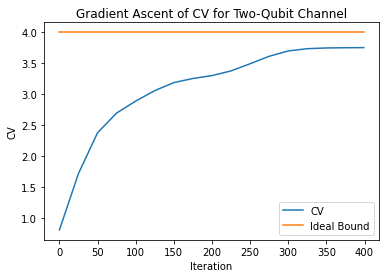

In [14]:
# Plot the communication value
plt.plot(d4_samples, d4_cvs, label = "CV")
plt.plot(d4_samples, [4]*len(d4_samples), label = "Ideal Bound")
plt.title("Gradient Ascent of CV for Two-Qubit Channel")
plt.xlabel("Iteration")
plt.ylabel("CV")
plt.legend()
plt.show()

## 4-Qubit Product Channel of Two 2-Qubit Channels

Setting up the product of 2-qubit channels as a 4-qubit `"default.mixed"` device.

In [15]:
noisy_2qubit_prod_dev = qml.device('default.mixed', wires=4)

# making mixed simulator aware of the new channel
noisy_2qubit_prod_dev.operations.update(["TwoQubitEntangledPauli"])

def _cv_noisy_2qubit_prod_circuit(settings, channel=None, *channel_params):
    (θ_state, θ_measurement) = settings
        
    qml.RY(θ_state[0], wires=0)
    qml.RY(θ_state[1], wires=1)
    qml.RY(θ_state[2], wires=2)
    qml.RY(θ_state[3], wires=3)
    
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,2])
    qml.CNOT(wires=[2,3])
    qml.CNOT(wires=[3,0])
    
    if channel != None:
        TwoQubitEntangledPauli(*channel_params, wires=[0,1])
        TwoQubitEntangledPauli(*channel_params, wires=[2,3])
    
    qml.CNOT(wires=[3,0])
    qml.CNOT(wires=[2,3])
    qml.CNOT(wires=[1,2])
    qml.CNOT(wires=[0,1])
    
    return qml.probs(wires=[0,1,2,3])

@qml.qnode(noisy_2qubit_prod_dev)
def cv_noisy_2qubit_prod_circuit(settings):
    return _cv_noisy_2qubit_prod_circuit(settings, TwoQubitEntangledPauli, 0)

cv_noisy_2qubit_prod_cost = lambda settings: _cv_cost(settings, cv_noisy_2qubit_prod_circuit)

Optimizing the communication value of the product channel circuit (this takes a while).

In [16]:
%%time

d16_final_cv, d16_settings, d16_cvs, d16_samples = cv_gradient_descent(
    16, cv_noisy_2qubit_prod_cost, step_size=20, num_steps=200
)

iteration :  0
cv :  1.4611391961143205
settings :
 [array([[ 2.29050768, -2.67402741, -1.75548915, -1.34848648],
       [-2.15494572, -2.55842197, -0.80031339, -2.45564021],
       [-2.75556643, -2.57664571,  1.13643563,  2.15686004],
       ...,
       [ 0.74297372,  0.4793648 ,  2.83269925,  0.50452896],
       [ 0.03473639,  0.96136183,  3.00352096,  1.9386542 ],
       [-2.27659122, -2.42747635, -1.93313421,  2.98572368]]), array([[-1.26911543,  1.4861889 ,  0.74216139,  1.78076455],
       [-2.90100701,  0.0234295 ,  2.90855244,  2.17133455],
       [ 0.35845804, -1.80886224,  0.68254176,  3.07418305],
       [-2.35316502, -1.92448627,  2.67230159, -2.63013329],
       [-1.41839995,  0.79092126,  2.41680415, -0.28420269],
       [-0.74327892,  1.88438395, -1.40214785,  1.03494805],
       [-1.16080568, -1.63689345,  1.66174274, -1.79882029],
       [-1.91195731, -0.89882421,  3.0967853 , -2.34924559],
       [ 2.46435679, -1.85153532, -2.81743544, -2.53624457],
       [-2.1963936

iteration :  130
iteration :  135
iteration :  140
iteration :  145
iteration :  150
cv :  13.876146679183151
settings :
 [array([[ 4.85722573e-17, -4.16333634e-17, -9.02056208e-17,
        -6.93889390e-18],
       [ 0.00000000e+00, -6.93889390e-18, -3.46944695e-17,
        -3.14159265e+00],
       [-2.20090822e+00, -2.12011387e+00,  1.39701406e+00,
         1.85666386e+00],
       ...,
       [ 7.48688443e-01,  4.88424639e-01,  2.81866143e+00,
         5.13126527e-01],
       [ 3.14159265e+00,  3.14159265e+00,  3.14159265e+00,
         6.24500451e-17],
       [-3.14159265e+00, -3.14159265e+00, -3.14159265e+00,
         3.14159265e+00]]), array([[-1.26911543,  1.4861889 ,  0.74216139,  1.78076455],
       [-2.90100701,  0.0234295 ,  2.90855244,  2.17133455],
       [ 0.35845804, -1.80886224,  0.68254176,  3.07418305],
       [-2.35316502, -1.92448627,  2.67230159, -2.63013329],
       [-1.41839995,  0.79092126,  2.41680415, -0.28420269],
       [-0.74327892,  1.88438395, -1.40214785,  

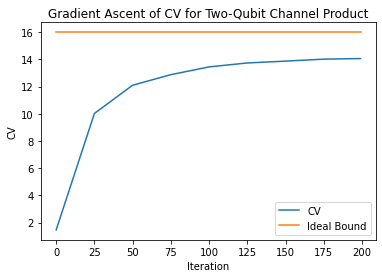

In [17]:
# Plot the communication value
plt.plot(d16_samples, d16_cvs, label = "CV")
plt.plot(d16_samples, [16]*len(d16_samples), label = "Ideal Bound")
plt.title("Gradient Ascent of CV for Two-Qubit Channel Product")
plt.xlabel("Iteration")
plt.ylabel("CV")
plt.legend()
plt.show()